# Introduction

## Install Dependencies

In [121]:
!pip install -U statsmodels tbats pmdarima

## Import Libraries

In [122]:
import pandas as pd
import numpy as np

## Load & Prepare Data

In [123]:
def load_binance_pair_from_file(data_path: str) -> pd.DataFrame:
    data = pd.read_json(data_path)
    data.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    data['time'] = pd.to_datetime(data['time'], unit='ms')
    data.set_index('time',inplace=True)
    
    return data.asfreq(freq='1H')

In [124]:
def load_bike_sales_from_file(data_path: str) -> pd.DataFrame:
    df = pd.read_csv(
        data_path,
        index_col='dteday',
        parse_dates=True).rename(columns = {'cnt' : 'y'}).asfreq("D")
    
    return df.loc[:,['y', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

In [125]:
#data = load_binance_pair_from_file('C:\\dev\\P\\fa.services.plutus\\user_data\\data\\binance\\DOGE_BTC-1h.json')
data = load_bike_sales_from_file('./../../data/daily_bike_sharing.csv')

## Visualize Data

<AxesSubplot:xlabel='dteday'>

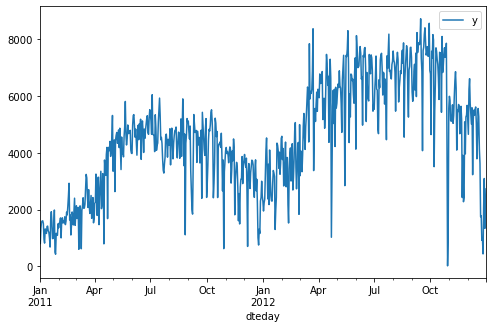

In [126]:
data['y'].plot(figsize=(8,5), legend=True)

# Seasonal Decomposition
- Basically split data into different groups (trends, seasonality and errors).
  - Trend - Most consistent line.
  - Seasonality - Somewhat consistent.
  - Error - Not consistent at all (no trend).

- Seasonality
  - Additive (absolute values)
  - Multiplicative (percentage values)

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose

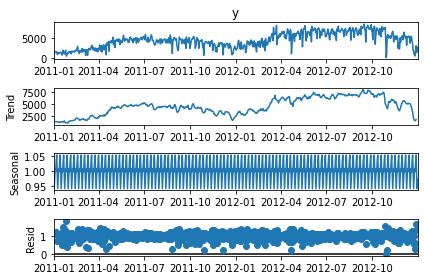

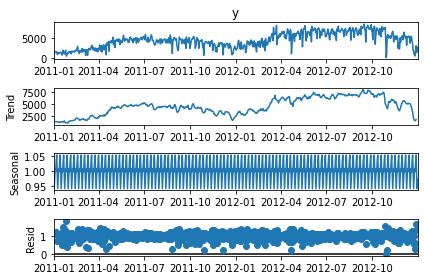

In [128]:
decomposition = seasonal_decompose(x=data.y, model='multiplicative')
decomposition.plot()

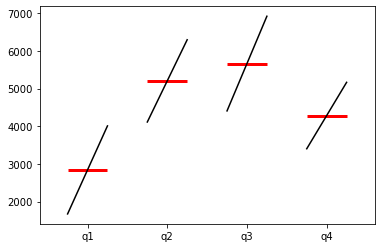

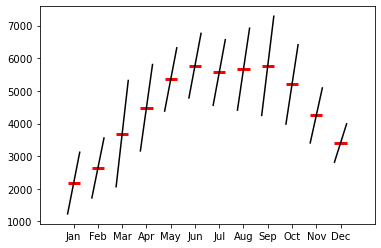

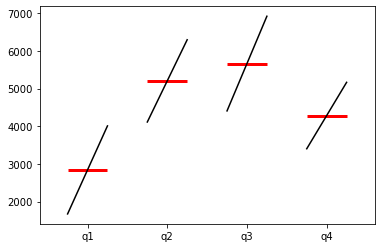

In [129]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

month_plot(data.y.resample(rule='MS').mean())
quarter_plot(data.y.resample(rule='Q').mean())

# Holt-Winters (Tripple Exponential Smoothing)
A specialized exponential smoothing mechanism (Older data has less value).

Pros:
- Easy to apply
- Easy to understand

Cons:
- No support for external regressors
- Low flexibility
- Better with low amount of time periods or frequency

## Exponential Smoothing
- Split timeseries data into 3 sets.
  - Level
  - Trend
  - Seasonality
- Perform exponential smoothing on all of the above.
- Manually figure out if we're using additive or multiplicative mechanisms.

In [130]:
# Training & Test Sets
test_hours = 31
training_set = data.iloc[:-test_hours, :]
test_set = data.iloc[-test_hours:, :]

print(training_set.shape)
print(test_set.shape)

(700, 8)
(31, 8)


In [131]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [132]:
# Forecasting model.
model = ExponentialSmoothing(
    endog=training_set.y, 
    trend='mul', 
    seasonal='mul').fit()

c:\Users\divanma\.conda\envs\windows-ml-station\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [133]:
# Predictions.
predictions_hw = model.forecast(steps=len(test_set)).rename('HW')

<AxesSubplot:xlabel='dteday'>

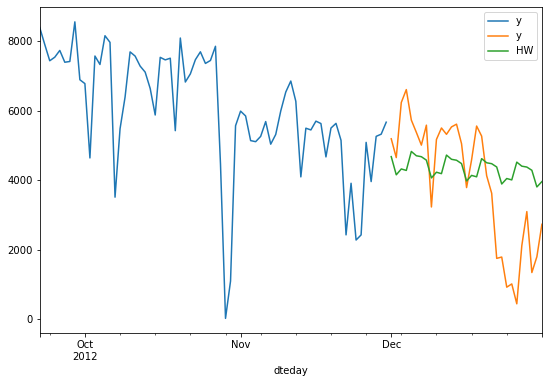

In [134]:
# Visualization
last_count_training_data_to_visualize = -(round(len(training_set)/10))
training_set['y'][last_count_training_data_to_visualize:].plot(figsize=(9,6), legend=True)
test_set['y'].plot(legend=True)
predictions_hw.plot(legend=True)

In [135]:
# Measurements
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [136]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [137]:
print(f'Mean Absolute Error: {mean_absolute_error(test_set.y, predictions_hw)}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(test_set.y, predictions_hw))}')
print(f'MAPE: {mape(test_set.y, predictions_hw)}')

Mean Absolute Error: 1388.5193251096878
Mean Squared Error: 1697.6845363545444
MAPE: 87.26099293841784


In [138]:
# Export Forecasts
#predictions_hw.to_csv('predictions_hw.csv', index=True)

# TBATS
Similar but better than exponential smoothing.

- Trigonometrics seasonality
- Box-cox transformation
- AutoRegressive moving average
- Trend
- Seasonality

Pros:
- Seasonality allowed to change over time.
- Automated optimization.
- Easy implementation.

Cons:
- Prediction intervals often wide.
- Does not allow external regressors.
- Slow.

In [139]:
from tbats import TBATS

In [140]:
# Forecasting
model = TBATS(seasonal_periods = [7, 365.5])
model = model.fit(training_set.y)

In [141]:
# Predictions
predictions_tbats = pd.Series(model.forecast(steps=len(test_set))).rename('TBATS')
predictions_tbats.index = test_set.index

<AxesSubplot:xlabel='dteday'>

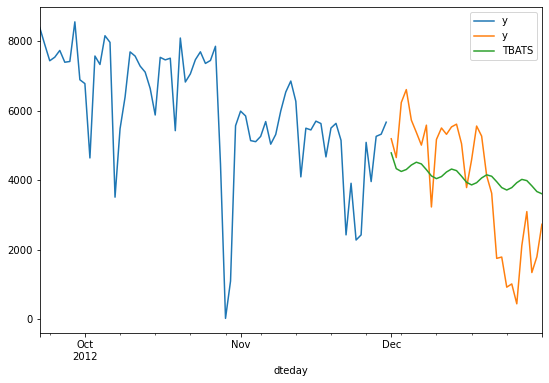

In [142]:
# Visualization
last_count_training_data_to_visualize = -(round(len(training_set)/10))
training_set['y'][last_count_training_data_to_visualize:].plot(figsize=(9,6), legend=True)
test_set['y'].plot(legend=True)
predictions_tbats.plot(legend=True)

In [143]:
print(f'Mean Absolute Error: {mean_absolute_error(test_set.y, predictions_tbats)}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(test_set.y, predictions_tbats))}')
print(f'MAPE: {mape(test_set.y, predictions_tbats)}')

Mean Absolute Error: 1371.0511778063112
Mean Squared Error: 1601.6653469045573
MAPE: 78.9307628204601


# ARIMA, SARIMA & SARIMAX
AutoRegressive integrated moving average, seasonal ARIMA and SARIMA + Exogenous variables.

In [144]:
# Determine  Stationarity
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [145]:
stationarity = adfuller(data.y)

print(f'Augmented Dickey Fuller p-value: {stationarity[1]}')

Augmented Dickey Fuller p-value: 0.34274344033921944


In [146]:
training_set.head()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [147]:
# Exogenous Variables (External regressors - moving seasonality, events outside company control as well as company events)
train_exog = training_set.iloc[:,1:]
test_exog = test_set.iloc[:,1:]

In [148]:
model = auto_arima(
    y=training_set.y,
    x= train_exog,
    m=7,
    seasonal=True,
    stepwise=False # when theres tons of data to optimize through.
)

In [149]:
# Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  700
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -5751.922
Date:                                Fri, 27 May 2022   AIC                          11517.845
Time:                                        13:25:06   BIC                          11549.692
Sample:                                             0   HQIC                         11530.157
                                                - 700                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6963      0.834      0.834      0.404      -0.939       2.332
ar.L1          0.3532      0.034     10.265      0.000       0.286       0.421
ma.L1         -0.9316      0.016    -59.241      0.000      -0.962      -0.901
ar.S.L7        0.8290      0.107      7.729      0.000       0.619       1.039
ma.S.L7       -0.8129      0.112     -7.236      0.000      -1.033      -0.593
ma.S.L14       0.0633      0.043      1.468      0.142      -0.021       0.148
sigma2      8.504e+05   2.82e+04     30.124      0.000    7.95e+05    9.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1278.10
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               3.68   Skew:                            -1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
# Predictions
predictions_sarimax = pd.Series(model.predict(
    n_periods=test_hours,
    x=test_exog
)).rename('SARIMAX')
predictions_sarimax.index = test_set.index

predictions_sarimax.head()

dteday
2012-12-01    5309.702249
2012-12-02    4889.102296
2012-12-03    4791.870585
2012-12-04    4713.444890
2012-12-05    4965.641595
Freq: D, Name: SARIMAX, dtype: float64

<AxesSubplot:xlabel='dteday'>

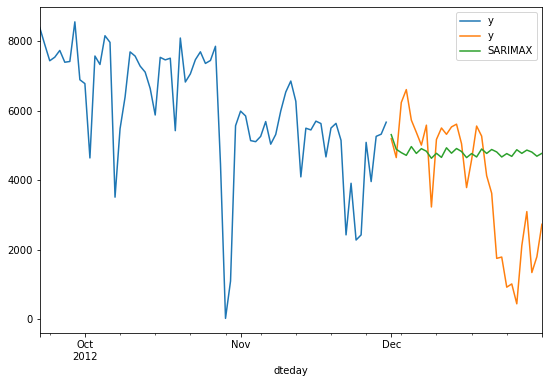

In [155]:
# Visualization
last_count_training_data_to_visualize = -(round(len(training_set)/10))
training_set['y'][last_count_training_data_to_visualize:].plot(figsize=(9,6), legend=True)
test_set['y'].plot(legend=True)
predictions_sarimax.plot(legend=True)

In [156]:
print(f'Mean Absolute Error: {mean_absolute_error(test_set.y, predictions_sarimax)}')
print(f'Mean Squared Error: {np.sqrt(mean_squared_error(test_set.y, predictions_sarimax))}')
print(f'MAPE: {mape(test_set.y, predictions_sarimax)}')

Mean Absolute Error: 1469.401390439885
Mean Squared Error: 1929.4133335213485
MAPE: 100.09711767552429
